Transaction Data for fraud

The link for the dataset: https://www.kaggle.com/datasets/isabbaggin/transaction-fraudulent-financial-syntheticdata

The dataset is entirely computer generated and does not contain any real-world information, ensuring privacy and data protection.

(The same dataset as in the previous project that is why I do not prepare data in this notebook)

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# if your Jupyter kernel crashes during this code, use this setting
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
# load data
df = pd.read_csv("cleaned_df.csv")
df

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_time_numeric
0,1,1082,2027,5758.59,0,2,30,0,43,2027,1672531200
1,2,1015,2053,1901.56,1,3,47,2,61,2053,1672531201
2,3,1004,2035,1248.86,1,2,6,0,57,2035,1672531202
3,4,1095,2037,7619.05,1,1,6,5,59,2037,1672531203
4,5,1036,2083,1890.10,1,2,34,4,36,2083,1672531204
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,8935.28,1,2,39,3,36,2023,1672541195
9996,9997,1053,2026,30.15,0,2,32,4,42,2026,1672541196
9997,9998,1041,2034,6333.64,0,0,1,2,36,2034,1672541197
9998,9999,1009,2019,2837.13,1,3,11,4,57,2019,1672541198


In [3]:
df.head()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description,transaction_time_numeric
0,1,1082,2027,5758.59,0,2,30,0,43,2027,1672531200
1,2,1015,2053,1901.56,1,3,47,2,61,2053,1672531201
2,3,1004,2035,1248.86,1,2,6,0,57,2035,1672531202
3,4,1095,2037,7619.05,1,1,6,5,59,2037,1672531203
4,5,1036,2083,1890.10,1,2,34,4,36,2083,1672531204


In [4]:
# we are going to select is_fraudulent and wind_speed as our target outputs
df = df.drop(['is_fraudulent', 'customer_age'], axis=1)

In [5]:
#  Scale the values (important in CNN)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# care only relevant variables
num_cols = ['customer_id', 'merchant_id', 'amount']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [6]:
df.head()

,transaction_id,customer_id,merchant_id,amount,card_type,location,purchase_category,transaction_description,transaction_time_numeric
0,1,0.818182,0.262626,0.575423,2,30,0,2027,1672531200
1,2,0.141414,0.525253,0.189301,3,47,2,2053,1672531201
2,3,0.030303,0.343434,0.123960,2,6,0,2035,1672531202
3,4,0.949495,0.363636,0.761671,1,6,5,2037,1672531203
4,5,0.353535,0.828283,0.188153,2,34,4,2083,1672531204


In [7]:
# instead of the date-column and old index,
# let's use a sequence number
# starting from 1 until the final row

# Add a sequence column starting from 1
df['sequence'] = df.index + 1

# drop the column
columns_to_drop = ['transaction_time_numeric']
df = df.drop(columns=columns_to_drop, axis=1)

# Reorder columns
columns = ['sequence'] + [col for col in df.columns if col != 'sequence']
df = df[columns]

In [8]:
 df.tail()

,sequence,transaction_id,customer_id,merchant_id,amount,card_type,location,purchase_category,transaction_description
9995,9996,9996,0.555556,0.222222,0.893437,2,39,3,2023
9996,9997,9997,0.525253,0.252525,0.001956,2,32,4,2026
9997,9998,9998,0.404040,0.333333,0.632990,0,1,2,2034
9998,9999,9999,0.080808,0.181818,0.282959,3,11,4,2019
9999,10000,10000,0.818182,0.696970,0.720665,1,1,0,2070


In [13]:
#  Split the DataFrame into timesteps
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

# separate the output variables
amount = df['amount'].values
location = df['location'].values

# generate timestep windows for each signal
amount_windows = sliding_window_view(amount, window_shape=timestep_size)
location_windows = sliding_window_view(location, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((amount_windows, location_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(amount_windows) + [1] * len(location_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (19902, 50)
y: (19902,)


In [14]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

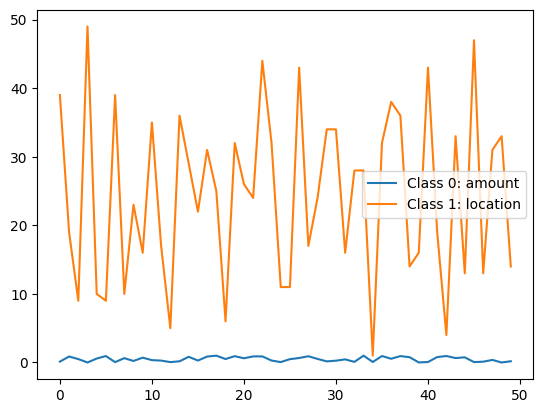

In [15]:
 test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: amount")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: location")
plt.legend()

In [16]:
#  Finally we can do the train/test split

# define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

13931
5971
13931
5971


In [17]:
x_train

array([[4.00000000e+01, 4.60000000e+01, 1.80000000e+01, ...,
        4.40000000e+01, 2.60000000e+01, 1.50000000e+01],
       [3.36527469e-01, 1.12962677e-02, 8.21075688e-01, ...,
        5.73956317e-01, 6.90082430e-01, 3.28057270e-01],
       [8.59819764e-01, 6.82883612e-01, 9.09561784e-01, ...,
        9.61930657e-01, 7.06086810e-01, 9.63679556e-01],
       ...,
       [3.60000000e+01, 2.30000000e+01, 1.70000000e+01, ...,
        1.20000000e+01, 2.80000000e+01, 3.50000000e+01],
       [7.02327728e-01, 9.80005286e-01, 4.59440953e-01, ...,
        3.56209844e-01, 6.85557515e-01, 1.87947111e-01],
       [3.60000000e+01, 5.00000000e+00, 8.00000000e+00, ...,
        1.50000000e+01, 9.00000000e+00, 4.90000000e+01]])

In [18]:
 # convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [19]:
 x_train

array([[[4.00000000e+01],
        [4.60000000e+01],
        [1.80000000e+01],
        ...,
        [4.40000000e+01],
        [2.60000000e+01],
        [1.50000000e+01]],

       [[3.36527469e-01],
        [1.12962677e-02],
        [8.21075688e-01],
        ...,
        [5.73956317e-01],
        [6.90082430e-01],
        [3.28057270e-01]],

       [[8.59819764e-01],
        [6.82883612e-01],
        [9.09561784e-01],
        ...,
        [9.61930657e-01],
        [7.06086810e-01],
        [9.63679556e-01]],

       ...,

       [[3.60000000e+01],
        [2.30000000e+01],
        [1.70000000e+01],
        ...,
        [1.20000000e+01],
        [2.80000000e+01],
        [3.50000000e+01]],

       [[7.02327728e-01],
        [9.80005286e-01],
        [4.59440953e-01],
        ...,
        [3.56209844e-01],
        [6.85557515e-01],
        [1.87947111e-01]],

       [[3.60000000e+01],
        [5.00000000e+00],
        [8.00000000e+00],
        ...,
        [1.50000000e+01],
        [9.0000

In [20]:
class_names = np.array(["is_fraudulent", "customer_age"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

In [21]:
from tensorflow import keras

epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# add the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,          
    restore_best_weights=True  
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9655 - val_loss: 1.4091e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4686e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3125e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4277e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.3889e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6157e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.2673e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2617e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3715e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/500
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0652e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3777e

<Axes: >

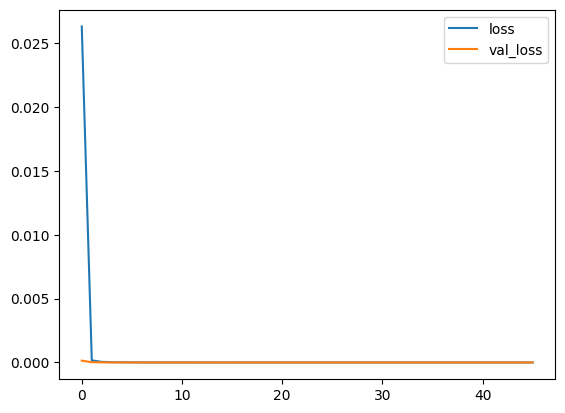

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

# the graph is almost the same as it was
# in the last project where I utilized CNN

<Axes: >

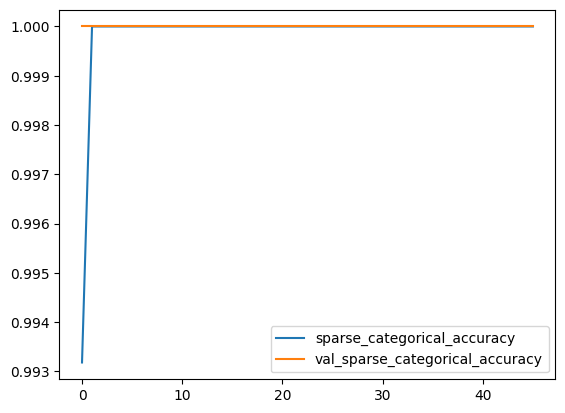

In [23]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [ ]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

# this is strange result
# probably, I have issues with labels:
# y_train and y_test

Test data evaluation:
[0.0, 1.0]

Train data evaluation:
[0.0, 1.0]


In [25]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

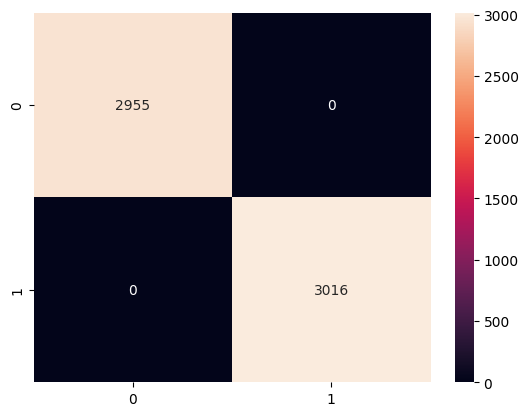

In [ ]:
 # confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# from my point of view,
# it is also too perfect to be real

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# the same thoughts as in the previous cell

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2955
           1       1.00      1.00      1.00      3016

    accuracy                           1.00      5971
   macro avg       1.00      1.00      1.00      5971
weighted avg       1.00      1.00      1.00      5971


Model overall accuracy: 100.00%


1
customer_age


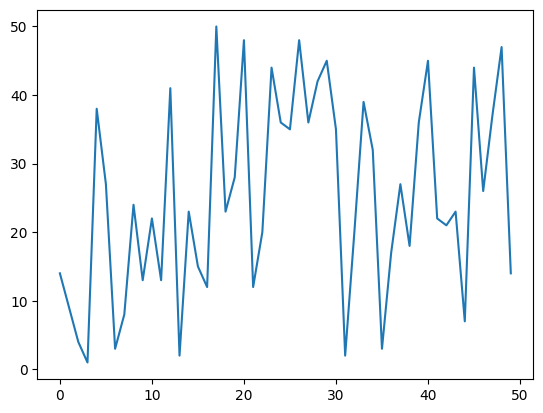

In [28]:
#  Test the model with some imaginary/synthetic signal examples from ChatGPT
signal_index = 8
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

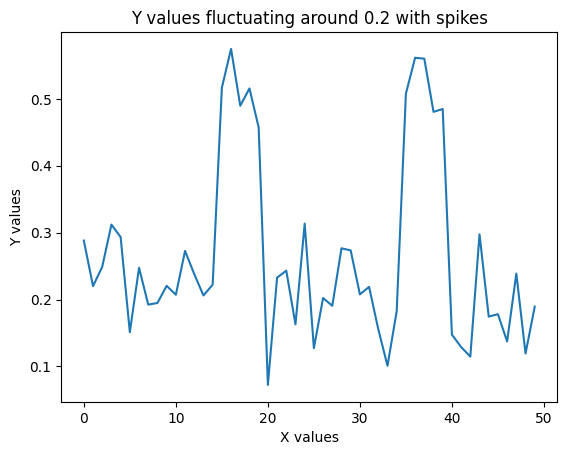

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.2
np.random.seed(0)  # For reproducibility
y = 0.2 + np.random.normal(0, 0.05, size=x.shape)

# Introduce spikes
y[15:20] += 0.3  # First spike
y[35:40] += 0.3  # Second spike

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.2 with spikes')
plt.show()

# y now contains the desired values

In [30]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[1.000000e+00 7.143239e-10]]
is_fraudulent


0
is_fraudulent


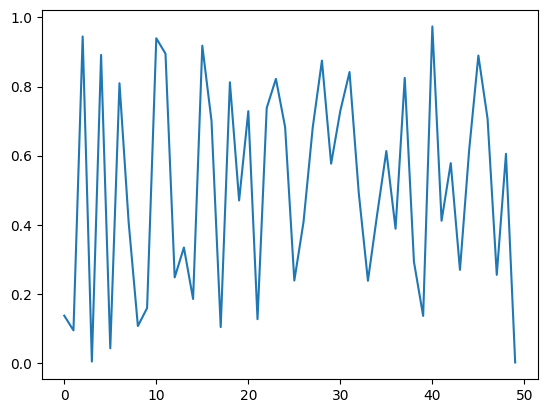

In [31]:
signal_index = 22
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

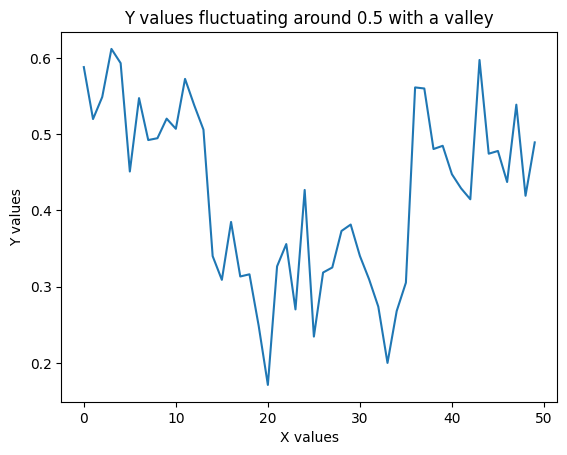

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values from 0 to 49
x = np.arange(50)

# Create y values that fluctuate around 0.5
np.random.seed(0)  # For reproducibility
y = 0.5 + np.random.normal(0, 0.05, size=x.shape)

# Introduce a valley around the middle (indices 20 to 30)
y[14:36] -= 0.2 + np.random.normal(0, 0.02, size=22)  # Valley around 0.2

# Optional: Clip y values to avoid extreme outliers
y = np.clip(y, 0, 1)

# Plot the result (optional)
plt.plot(x, y)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Y values fluctuating around 0.5 with a valley')
plt.show()

# y now contains the desired values

In [33]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[1.0000000e+00 9.1295477e-10]]
is_fraudulent
